In [15]:
import os
import hashlib
import json
import tempfile
import time
import subprocess
from pptx import Presentation
from pdf2image import convert_from_path
from PyPDF2 import PdfReader
from PIL import Image
import google.generativeai as genai
from concurrent.futures import ThreadPoolExecutor, as_completed

In [62]:
def compute_presentation_hash(pptx_file_path):
    """
    Computes a SHA-256 hash of the presentation file for unique identification.
    """
    BUF_SIZE = 65536  # Read in 64KB chunks
    sha256 = hashlib.sha256()
    with open(pptx_file_path, 'rb') as f:
        while True:
            data = f.read(BUF_SIZE)
            if not data:
                break
            sha256.update(data)
    return sha256.hexdigest()


def extract_presentation_info(presentation_file_path, is_pdf=False, config=None):
    """
    Extracts metadata and high-level information from the presentation.

    Parameters:
    - presentation_file_path: Path to the presentation file.
    - is_pdf: Boolean indicating if the file is a PDF.
    - config: Dictionary specifying which metadata properties to extract.

    Returns:
    - presentation_info: Dictionary containing the requested metadata.
    """

    all_metadata = {}

    # Basic Metadata
    file_stats = os.stat(presentation_file_path)
    all_metadata['file_name'] = os.path.basename(presentation_file_path)
    all_metadata['file_format'] = os.path.splitext(presentation_file_path)[1]
    all_metadata['file_size_bytes'] = file_stats.st_size  # in bytes
    all_metadata['file_path'] = os.path.abspath(presentation_file_path)
    all_metadata['creation_date'] = time.ctime(file_stats.st_ctime)
    all_metadata['last_modified_date'] = time.ctime(file_stats.st_mtime)
    # Version is not typically available

    if not is_pdf:
        presentation = Presentation(presentation_file_path)
        core_properties = presentation.core_properties

        all_metadata['number_of_slides'] = len(presentation.slides)
        all_metadata['title'] = core_properties.title
        all_metadata['author'] = core_properties.author
        all_metadata['subject'] = core_properties.subject
        all_metadata['description'] = core_properties.comments
        all_metadata['keywords'] = core_properties.keywords
        all_metadata['last_modified_by'] = core_properties.last_modified_by
        all_metadata['created'] = core_properties.created.isoformat() if core_properties.created else None
        all_metadata['modified'] = core_properties.modified.isoformat() if core_properties.modified else None
        all_metadata['last_printed'] = core_properties.last_printed.isoformat() if core_properties.last_printed else None
        all_metadata['language'] = core_properties.language
        # Additional metadata extraction can be added here

    else:
        reader = PdfReader(presentation_file_path)
        doc_info = reader.metadata

        all_metadata['number_of_slides'] = len(reader.pages)
        all_metadata['title'] = doc_info.title if doc_info.title else None
        all_metadata['author'] = doc_info.author if doc_info.author else None
        all_metadata['subject'] = doc_info.subject if doc_info.subject else None
        all_metadata['keywords'] = doc_info.get('/Keywords')
        all_metadata['creator'] = doc_info.creator if doc_info.creator else None
        all_metadata['producer'] = doc_info.producer if doc_info.producer else None
        all_metadata['creation_date'] = doc_info.get('/CreationDate')
        all_metadata['mod_date'] = doc_info.get('/ModDate')
        all_metadata['encrypted'] = reader.is_encrypted
        all_metadata['pdf_version'] = reader.pdf_header
        # Additional PDF-specific metadata extraction can be added here

    # Filter metadata based on config
    if config:
        presentation_info = {key: all_metadata.get(key) for key in config if config[key]}
    else:
        presentation_info = all_metadata

    return presentation_info


def extract_slide_texts(presentation_source, slides_to_process=None, is_pdf=False):
    """
    Extracts text content from each slide.

    Parameters:
    - presentation_source: Presentation object or file path.
    - slides_to_process: List of slide numbers to process.
    - is_pdf: Boolean indicating if the file is a PDF.

    Returns:
    - slide_texts: List of texts extracted from each slide.
    """
    slide_texts = []
    if not is_pdf:
        # For PPTX files
        for i, slide in enumerate(presentation_source.slides):
            slide_number = i + 1
            if slides_to_process and slide_number not in slides_to_process:
                continue
            text_runs = []
            for shape in slide.shapes:
                if hasattr(shape, "text"):
                    text_runs.append(shape.text)
            slide_texts.append('\n'.join(text_runs))
    else:
        # For PDF files
        reader = PdfReader(presentation_source)
        for i, page in enumerate(reader.pages):
            slide_number = i + 1
            if slides_to_process and slide_number not in slides_to_process:
                continue
            text = page.extract_text()
            slide_texts.append(text)
    return slide_texts


def generate_slide_images(presentation_file_path, image_output_path, slides_to_process=None, image_format='PNG', resize_option=None, is_pdf=False):
    """
    Generates image versions of the slides.

    Parameters:
    - presentation_file_path: Path to the presentation file.
    - image_output_path: Directory to save the slide images.
    - slides_to_process: List of slide numbers to process (default is all slides).
    - image_format: Format for the slide images (default is 'PNG').
    - resize_option: Tuple (width, height) to resize the images. If None, no resizing is done.
    - is_pdf: Boolean indicating if the file is a PDF.

    Returns:
    - slide_image_paths: List of paths to the slide images.
    """
    # Ensure the output directory exists
    if not os.path.exists(image_output_path):
        os.makedirs(image_output_path)

    images=None
        
    # If the file is not a PDF, convert it to PDF first
    if not is_pdf:
        folder_path = os.path.dirname(presentation_file_path)
        file_name = os.path.basename(presentation_file_path)
        file_name_without_extension = os.path.splitext(file_name)[0]

        subprocess.run(['libreoffice', '--convert-to', 'pdf', presentation_file_path, '--outdir', folder_path], check=True)
        presentation_pdf_path = folder_path + '/' + file_name_without_extension + '.pdf'
        # Convert PDF pages to images
        images = convert_from_path(presentation_pdf_path)

    else:
        presentation_pdf_path = presentation_file_path
        # Convert PDF pages to images
        images = convert_from_path(presentation_pdf_path)

    slide_image_paths = []
    for i, image in enumerate(images):
        slide_number = i + 1
        if slides_to_process and slide_number not in slides_to_process:
            continue
        if resize_option:
            image = image.resize(resize_option)
        slide_image_name = f'slide_{slide_number}.{image_format.lower()}'
        slide_image_path = os.path.join(image_output_path, slide_image_name)
        image.save(slide_image_path, image_format.upper())
        slide_image_paths.append(slide_image_path)
    return slide_image_paths

def process_presentation(presentation_file_path, image_output_path, 
                         slides_to_process=None, image_format='PNG', 
                         output_json_path=None, resize_option=None, config=None):
    """
    Processes the presentation (PPTX or PDF) and returns a dictionary with the extracted information.

    Parameters:
    - presentation_file_path: Path to the presentation file (PPTX or PDF).
    - image_output_path: Directory to save the slide images.
    - slides_to_process: List of slide numbers to process (default is all slides).
    - image_format: Format for the slide images (default is 'PNG').
    - output_json_path: Path to save the output dictionary as a JSON file (optional).
    - resize_option: Tuple (width, height) to resize the slide images. If None, no resizing is done.
    - config: Dictionary specifying which metadata properties to extract.

    Returns:
    - presentation_info: Dictionary containing presentation info and slides info.
    """
    # Compute a unique hash for the presentation
    presentation_hash = compute_presentation_hash(presentation_file_path)

    # Determine the file type
    file_name, file_extension = os.path.splitext(presentation_file_path)
    file_extension = file_extension.lower()

    # Extract high-level presentation info
    if file_extension == '.pptx':
        presentation_info = extract_presentation_info(presentation_file_path, config=config)
        presentation = Presentation(presentation_file_path)
    elif file_extension == '.pdf':
        presentation_info = extract_presentation_info(presentation_file_path, is_pdf=True, config=config)
        presentation = None  # We'll handle PDFs differently
    else:
        raise ValueError("Unsupported file format. Only .pptx and .pdf files are supported.")

    presentation_info['presentation_hash'] = presentation_hash
    presentation_info['presentation_file_name'] = os.path.basename(presentation_file_path)

    # Generate slide images
    slide_image_paths = generate_slide_images(presentation_file_path, image_output_path, slides_to_process, image_format, resize_option, is_pdf=(file_extension == '.pdf'))

    # Extract slide texts
    if file_extension == '.pptx':
        slide_texts = extract_slide_texts(presentation, slides_to_process)
    elif file_extension == '.pdf':
        slide_texts = extract_slide_texts(presentation_file_path, slides_to_process, is_pdf=True)

    # Build the output dictionary
    slides_info = []
    for i, (text, image_path) in enumerate(zip(slide_texts, slide_image_paths)):
        slide_number = slides_to_process[i] if slides_to_process else i + 1
        slide_info = {
            'slide_number': slide_number,
            'text_content': text,
            'image_path': image_path
        }
        slides_info.append(slide_info)

    presentation_info['slides'] = slides_info

    # Save to JSON file if specified
    if output_json_path:
        with open(output_json_path, 'w', encoding='utf-8') as f:
            json.dump(presentation_info, f, ensure_ascii=False, indent=4)

    return presentation_info



def generate_text_from_image(image_path, prompt, resize_option=None, 
                             use_file_api=False, model_name='gemini-1.5-flash', 
                             api_call_sleep_seconds=0):
    """
    Generates a text description based on the image and prompt using the Gemini API.

    Parameters:
    - image_path: Path to the image file.
    - prompt: Text prompt to guide the model.
    - resize_option: Tuple (width, height) to resize the image. If None, no resizing is done.
    - use_file_api: Boolean indicating whether to upload the image using the File API.
    - model_name: The name of the Gemini model to use ('gemini-1.5-flash' or 'gemini-1.5-pro').

    Returns:
    - result: Dictionary containing:
        - 'response_text': The generated text from the model, or None if an error occurred.
        - 'error_flag': Boolean indicating if an error occurred (True if an error occurred).
        - 'error_message': Description of the error if one occurred, otherwise an empty string.
    """
    result = {
        'response_text': None,
        'error_flag': False,
        'error_message': ''
    }
    
    try:
        # Configure the API key (Assuming the API key is set as an environment variable)
        genai.configure(api_key=os.environ.get('GOOGLE_API_KEY'))

        time.sleep(api_call_sleep_seconds)
        
        # Open the image
        image = Image.open(image_path)

        # Resize the image if needed
        if resize_option:
            image = image.resize(resize_option)

        if use_file_api:
            # Upload the image using the File API
            myfile = genai.upload_file(image_path)
            # Create a model instance
            model = genai.GenerativeModel(model_name=model_name)
            # Generate content
            result_obj = model.generate_content(
                [myfile, "\n\n", prompt]
            )
        else:
            # Send the image data inline
            model = genai.GenerativeModel(model_name=model_name)
            result_obj = model.generate_content(
                [image, "\n\n", prompt]
            )

        result['response_text'] = result_obj.text
        print(f'________Generated image description for: {image_path}')
        
    except Exception as e:
        # Capture any error that occurs during the process
        result['error_flag'] = True
        result['error_message'] = str(e)
        print(f'Error occurred: {e}')
    
    return result


def generate_texts_from_images(image_prompt_list, resize_option=None, 
                               use_file_api=False, model_name='gemini-1.5-flash', 
                               parallel=False, api_call_sleep_seconds=0):
    """
    Generates text descriptions based on the images and prompts using the Gemini API.

    Parameters:
    - image_prompt_list: List of tuples (image_path, prompt).
    - resize_option: Tuple (width, height) to resize the images. If None, no resizing is done.
    - use_file_api: Boolean indicating whether to upload the images using the File API.
    - model_name: The name of the Gemini model to use.
    - parallel: Boolean indicating whether to parallelize the calls.

    Returns:
    - responses: List of response texts.
    """
    # Configure the API key (Assuming the API key is set as an environment variable)
    genai.configure(api_key=os.environ.get('GOOGLE_API_KEY'))
    
    def process_image_prompt(image_path, prompt):
        return generate_text_from_image(image_path, prompt, resize_option, 
                                        use_file_api, model_name, api_call_sleep_seconds)

    if parallel:
        responses = []
        with ThreadPoolExecutor() as executor:
            future_to_image = {executor.submit(process_image_prompt, image_path, prompt): (image_path, prompt) for image_path, prompt in image_prompt_list}
            for future in as_completed(future_to_image):
                try:
                    response = future.result()
                    responses.append(response)
                except Exception as exc:
                    print(f'Generated an exception: {exc}')
    else:
        responses = [process_image_prompt(image_path, prompt) for image_path, prompt in image_prompt_list]
    return responses




### Project directory structure

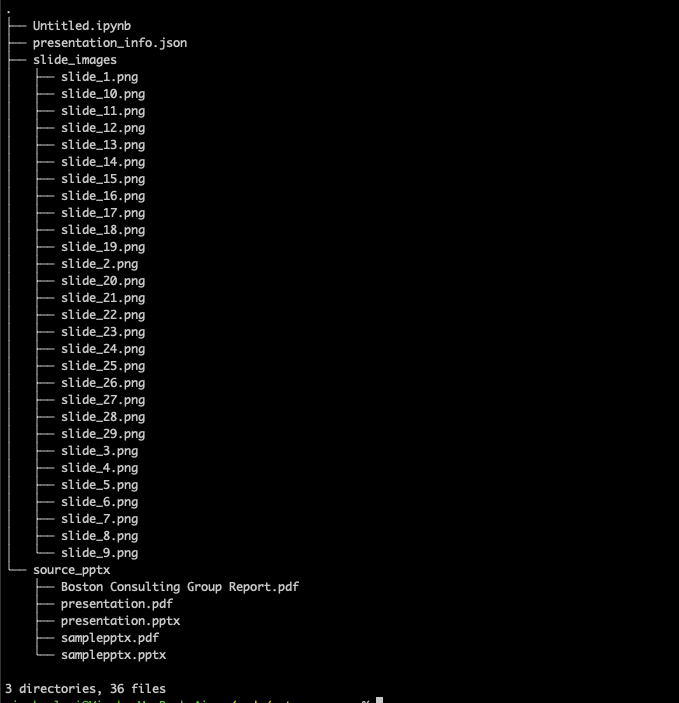

#### PDF presentation example

In [64]:
# You can now use either a PPTX or a PDF file
presentation_file = './source_pptx/Boston Consulting Group Report.pdf'  # Or 'sample_presentation.pptx'
image_output_dir = 'slide_images'
output_json = 'presentation_info.json'
slides_to_process = [27, 28, 29]  # Set to a list like [1, 2, 3] to process specific slides
resize_option = (1024, 768)  # Resize images to 1024x768 pixels

# Define the config for metadata extraction
pdf_config = {
    # Basic Metadata
    'file_name': True,
    'file_format': True,
    'file_size': True,
    'file_path': True,
    'creation_date': True,  # May need parsing from '/CreationDate'
    'last_modified_date': True,  # May need parsing from '/ModDate'
    
    # Document Properties
    'number_of_slides': True,  # Equivalent to number of pages
    'title': True,
    'subject': True,
    'author': True,
    'creator': True,
    'producer': True,
    'keywords': True,
    'pdf_version': True,
    'encrypted': True,
    'mod_date': True,  # Modification date
    
    # Optional (May require additional handling)
    # 'optimized': True,       # Not directly available
    # 'encryption_status': True  # Already included as 'encrypted'
}

config = pdf_config

# Process the presentation
presentation_data = process_presentation(
    presentation_file_path=presentation_file,
    image_output_path=image_output_dir,
    slides_to_process=slides_to_process,
    image_format='PNG',
    output_json_path=output_json,
    resize_option=resize_option,
    config=config
)

# Print the presentation data
print(json.dumps(presentation_data, indent=4))

# Generate text descriptions for each slide image
image_prompt_list = []
prompt = "Provide a summary of this slide."
for slide in presentation_data['slides']:
    image_path = slide['image_path']
    image_prompt_list.append((image_path, prompt))

# Generate text descriptions
descriptions = generate_texts_from_images(
    image_prompt_list=image_prompt_list,
    resize_option=None,  # Images are already resized during slide image generation
    use_file_api=False,
    model_name='gemini-1.5-flash',
    parallel=False,  # Set to True to parallelize the calls
    api_call_sleep_seconds=5
)

# Add the descriptions to the presentation data
for slide, description in zip(presentation_data['slides'], descriptions):
    slide['generated_description'] = description

# Save the updated presentation data to JSON
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(presentation_data, f, ensure_ascii=False, indent=4)

# Print the descriptions
for i, description in enumerate(descriptions):
    print(f"Slide {i+1} description:\n{description}\n")

{
    "file_name": "Boston Consulting Group Report.pdf",
    "file_format": ".pdf",
    "file_size": null,
    "file_path": "/Users/vivekavlani/code/pptx_parser/source_pptx/Boston Consulting Group Report.pdf",
    "creation_date": "D:20240924204254",
    "last_modified_date": "Tue Sep 24 20:43:22 2024",
    "number_of_slides": 29,
    "title": null,
    "subject": null,
    "author": null,
    "creator": "PDFium",
    "producer": "PDFium",
    "keywords": null,
    "pdf_version": "%PDF-1.7",
    "encrypted": false,
    "mod_date": null,
    "presentation_hash": "2ea35016b726f74fd86e3e58cf28ed5efe25298ebe79f04d00f60d94b25d1baf",
    "presentation_file_name": "Boston Consulting Group Report.pdf",
    "slides": [
        {
            "slide_number": 27,
            "text_content": "26\nFord is the most popular pickup \ntruck across commercial vocations\n75%Ford is the \nmost popular\ntruck in \nof vocations2\n40%\n25%\nAll othersFleet market share1\n(sizes proportional)% of 2019 new comm

### PPTX file example

In [65]:
pptx_config = {
    # Basic Metadata
    'file_name': True,
    'file_format': True,
    'file_size': True,
    'file_path': True,
    'creation_date': True,
    'last_modified_date': True,
    
    # Presentation Properties
    'number_of_slides': True,
    'title': True,
    'subject': True,
    'author': True,
    'last_modified_by': True,
    'description': True,
    'keywords': True,
    'created': True,
    'modified': True,
    'last_printed': True,
    'language': True,
    
    # Optional (May require additional handling)
    # 'template_used': True,  # Not directly extractable
    # 'fonts': True,          # Requires parsing slide content
    # 'images_media': True,   # Requires parsing slide content
    # 'encryption_status': True  # Not directly available
}

# You can now use either a PPTX or a PDF file
# presentation_file = './source_pptx/presentation.pptx'  # Or 'sample_presentation.pptx'

presentation_file = './source_pptx/samplepptx.pptx' 

image_output_dir = 'slide_images'
output_json = 'presentation_info.json'
slides_to_process = None  # Set to a list like [1, 2, 3] to process specific slides
resize_option = (1024, 768)  # Resize images to 1024x768 pixels

# Define the config for metadata extraction
config = pptx_config

# Process the presentation
presentation_data = process_presentation(
    presentation_file_path=presentation_file,
    image_output_path=image_output_dir,
    slides_to_process=slides_to_process,
    image_format='PNG',
    output_json_path=output_json,
    resize_option=resize_option,
    config=config
)

# Print the presentation data
print(json.dumps(presentation_data, indent=4))

# Generate text descriptions for each slide image
image_prompt_list = []
prompt = "Provide a summary of this slide."
for slide in presentation_data['slides']:
    image_path = slide['image_path']
    image_prompt_list.append((image_path, prompt))

# Generate text descriptions
descriptions = generate_texts_from_images(
    image_prompt_list=image_prompt_list,
    resize_option=None,  # Images are already resized during slide image generation
    use_file_api=False,
    model_name='gemini-1.5-flash',
    parallel=False,  # Set to True to parallelize the calls
    api_call_sleep_seconds=5
)

# Add the descriptions to the presentation data
for slide, description in zip(presentation_data['slides'], descriptions):
    slide['generated_description'] = description

# Save the updated presentation data to JSON
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(presentation_data, f, ensure_ascii=False, indent=4)

# Print the descriptions
for i, description in enumerate(descriptions):
    print(f"Slide {i+1} description:\n{description}\n")

convert /Users/vivekavlani/code/pptx_parser/source_pptx/samplepptx.pptx as a Impress document -> /Users/vivekavlani/code/pptx_parser/source_pptx/samplepptx.pdf using filter : impress_pdf_Export
{
    "file_name": "samplepptx.pptx",
    "file_format": ".pptx",
    "file_size": null,
    "file_path": "/Users/vivekavlani/code/pptx_parser/source_pptx/samplepptx.pptx",
    "creation_date": "Tue Sep 24 23:21:35 2024",
    "last_modified_date": "Tue Sep 24 23:21:25 2024",
    "number_of_slides": 2,
    "title": "Sample PowerPoint File",
    "subject": "",
    "author": "James Falkofske",
    "last_modified_by": "James Falkofske",
    "description": "",
    "keywords": "",
    "created": "2009-05-06T22:06:09",
    "modified": "2009-05-06T22:13:30",
    "last_printed": null,
    "language": "",
    "presentation_hash": "4a228ef8ac1a6db8b690534dcc0501b95e849b2694b8504d07e56099640753ee",
    "presentation_file_name": "samplepptx.pptx",
    "slides": [
        {
            "slide_number": 1,
    